# Investigating Sex Signature Features

**Gregory Way, 2019**

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import preprocessing

sys.path.append("../8.gtex-interpret")
from scripts.utils import load_weight_matrix, apply_signature

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline

## Load and Process Gene Dictionary

In [4]:
# Load curated gene names from versioned resource 
commit = '721204091a96e55de6dcad165d6d8265e67e2a48'
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/genes.tsv'.format(commit)

gene_df = pd.read_table(url)

symbol_to_entrez = dict(zip(gene_df.symbol,
                            gene_df.entrez_gene_id))

gene_df = gene_df.dropna(axis='rows', subset=['synonyms'])
gene_df.synonyms = gene_df.synonyms.str.split('|')

all_syn = (
    gene_df.apply(lambda x: pd.Series(x.synonyms), axis=1)
    .stack()
    .reset_index(level=1, drop=True)
)

# Name the synonym series and join with rest of genes
all_syn.name = 'all_synonyms'
gene_with_syn_df = gene_df.join(all_syn)

# Remove rows that have redundant symbols in all_synonyms
gene_with_syn_df = (
    gene_with_syn_df
    
    # Drop synonyms that are duplicated - can't be sure of mapping
    .drop_duplicates(['all_synonyms'], keep=False)

    # Drop rows in which the symbol appears in the list of synonyms
    .query('symbol not in all_synonyms')
)

# Create a synonym to entrez mapping and add to dictionary
synonym_to_entrez = dict(zip(gene_with_syn_df.all_synonyms,
                             gene_with_syn_df.entrez_gene_id))

symbol_to_entrez.update(synonym_to_entrez)

# Load gene updater
url = 'https://raw.githubusercontent.com/cognoma/genes/{}/data/updater.tsv'.format(commit)
updater_df = pd.read_table(url)
old_to_new_entrez = dict(zip(updater_df.old_entrez_gene_id,
                             updater_df.new_entrez_gene_id))

gene_df.entrez_gene_id = gene_df.entrez_gene_id.astype(str)

print(gene_df.shape)
gene_df.head()

(25864, 7)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases
0,1,A1BG,alpha-1-B glycoprotein,19,protein-coding,"[A1B, ABG, GAB, HYST2477]",alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...
1,2,A2M,alpha-2-macroglobulin,12,protein-coding,"[A2MD, CPAMD5, FWP007, S863-7]",alpha-2-macroglobulin|C3 and PZP-like alpha-2-...
2,3,A2MP1,alpha-2-macroglobulin pseudogene 1,12,pseudo,[A2MP],pregnancy-zone protein pseudogene
3,9,NAT1,N-acetyltransferase 1,8,protein-coding,"[AAC1, MNAT, NAT-1, NATI]",arylamine N-acetyltransferase 1|N-acetyltransf...
4,10,NAT2,N-acetyltransferase 2,8,protein-coding,"[AAC2, NAT-2, PNAT]",arylamine N-acetyltransferase 2|N-acetyltransf...


## Load and Proces Sex Genes

Using the resource `Sex-Associated Gene Database` (SAGD) ([Shi et al. 2018](https://doi.org/10.1093/nar/gky1040))

Downloading from http://bioinfo.life.hust.edu.cn/SAGD#!/browse_gene

Selecting human species, all tissues, all stages. The downloaded file is included in this repo.

In [5]:
sex_gene_file = os.path.join("download", "browse_gene_9606.csv")
sex_gene_df = pd.read_csv(sex_gene_file)

# Translate the symbol column to entrez_gene_id
sex_gene_map = sex_gene_df.Symbol.replace(symbol_to_entrez)
sex_gene_map = sex_gene_map.replace(old_to_new_entrez)
sex_gene_df = sex_gene_df.assign(entrez_gene_id=sex_gene_map)

# Median collapse duplicate gene IDs across SAGD groups 
sex_gene_df = (
    sex_gene_df
    .groupby(["Species", "Symbol", "entrez_gene_id"])
    .median()
    .sort_values(by="Padj")
    .reset_index()
)

sex_gene_df.entrez_gene_id = sex_gene_df.entrez_gene_id.astype(str)
sex_gene_df = sex_gene_df.assign(neg_log_p=-1 * np.log10(sex_gene_df.Padj + 1e-300))

print(sex_gene_df.shape)
sex_gene_df.head()

(20609, 8)


,Species,Symbol,entrez_gene_id,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,Human,SLC14A1,6563,27.874189,3.817723,-2.8677,0.0,300.0
1,Human,YBX2,51087,0.247333,265.826510,9.7604,0.0,300.0
2,Human,CDC42EP3,10602,36.431852,7.743798,-2.2178,0.0,300.0
3,Human,FNIP2,57600,19.594866,3.038489,-2.6634,0.0,300.0
4,Human,C1orf198,84886,61.916238,3.968032,-3.9609,0.0,300.0


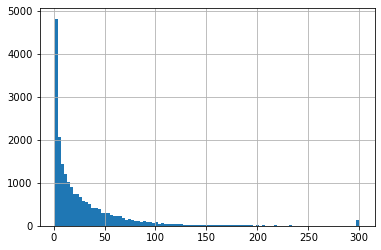

In [6]:
sex_gene_df.neg_log_p.hist(bins=100)

## Load Sex Signatures

In [7]:
gtex_seed = '486191'
gtex_k = 200
gtex_feature = "vae_108"

In [8]:
# Load the gtex weight matrix containing the best sex feature
gtex_weight_df = (
    load_weight_matrix(dataset='GTEX',
                       z_dim=gtex_k,
                       seed=gtex_seed)
    .reset_index()
)
gtex_weight_df.gene_id = gtex_weight_df.gene_id.astype(str)

gtex_weight_df.head()

,gene_id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,dae_190,dae_191,dae_192,dae_193,dae_194,dae_195,dae_196,dae_197,dae_198,dae_199
0,3043,0.004391,-0.003971,0.001468,-0.011569,0.008503,-0.004571,0.018591,-0.003835,-0.001917,...,-0.233910,-0.085938,-0.106765,-0.060279,-0.223284,-0.174022,0.286397,0.091351,0.011954,-0.218361
1,3040,0.003391,-0.003177,0.001366,-0.009521,0.007051,-0.003626,0.015497,-0.003466,-0.001718,...,-0.168975,-0.020008,-0.116555,-0.060639,-0.229734,-0.118382,0.046755,0.019056,-0.099575,-0.197872
2,6280,0.001972,-0.005423,0.007663,-0.005640,0.003097,-0.007758,0.019760,-0.003448,-0.006478,...,-0.203111,0.120740,0.073684,-0.171914,-0.263913,-0.163933,-0.096536,0.038661,0.037185,-0.191877
3,5644,0.003685,-0.002328,0.000388,-0.003179,0.000970,0.000403,-0.006603,0.004101,-0.003913,...,-0.140920,-0.080859,0.064645,0.005540,-0.133236,-0.065185,0.037012,-0.000036,0.074205,-0.151968
4,2512,-0.005885,-0.008677,-0.006711,-0.010242,0.016632,-0.020805,0.005641,-0.003083,0.007285,...,-0.100317,0.040262,-0.108991,-0.022068,-0.168687,-0.112921,-0.073029,-0.092680,0.033855,-0.152203


In [9]:
# Align the weight matrix to the Sex Gene Database
gtex_sex_feature = (
    gtex_weight_df
    .merge(gene_df,
           left_on="gene_id",
           right_on="entrez_gene_id",
           how="left")
    .loc[:, gene_df.columns.tolist() + [gtex_feature]]
    .assign(abs_value_feature = gtex_weight_df.loc[:, gtex_feature].abs().tolist())
)

gtex_sex_feature.entrez_gene_id = gtex_sex_feature.entrez_gene_id.astype(str)

gtex_sex_feature = (
    gtex_sex_feature
    .merge(sex_gene_df,
           left_on="entrez_gene_id",
           right_on="entrez_gene_id",
           how="left")
    .sort_values(by="abs_value_feature", ascending=False)
    .dropna(subset=["entrez_gene_id", "Padj"])
    .reset_index(drop=True)
)

print(gtex_sex_feature.shape)

# Show the top 10 genes
gtex_sex_feature.head(10)

(2384, 16)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases,vae_108,abs_value_feature,Species,Symbol,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,6192,RPS4Y1,"ribosomal protein S4, Y-linked 1",Y,protein-coding,"[RPS4Y, S4]","40S ribosomal protein S4, Y isoform 1|40S ribo...",-0.446378,0.446378,Human,RPS4Y1,0.169340,79.083927,8.69070,7.218300e-236,235.141565
1,8284,KDM5D,lysine demethylase 5D,Y,protein-coding,"[HY, HYA, JARID1D, SMCY]","lysine-specific demethylase 5D|H-Y|Jumonji, AT...",-0.430725,0.430725,Human,KDM5D,0.023831,9.706349,8.96300,1.009195e-222,221.996025
2,8653,DDX3Y,"DEAD-box helicase 3, Y-linked",Y,protein-coding,[DBY],ATP-dependent RNA helicase DDX3Y|DEAD (Asp-Glu...,-0.387692,0.387692,Human,DDX3Y,0.041641,17.594382,8.72735,1.208356e-214,213.917805
3,6406,SEMG1,semenogelin I,20,protein-coding,"[CT103, SEMG, SGI, dJ172H20.2]",semenogelin-1|SgI-29|cancer/testis antigen 103...,-0.254418,0.254418,Human,SEMG1,0.002702,0.131467,3.83065,1.630790e-02,1.787602
4,796,CALCA,calcitonin related polypeptide alpha,11,protein-coding,"[CALC1, CGRP, CGRP-I, CGRP1, CT, KC, PCT]",calcitonin|calcitonin gene-related peptide 1|a...,-0.245177,0.245177,Human,CALCA,9.188879,6.598638,5.46320,6.888900e-03,2.161850
5,4314,MMP3,matrix metallopeptidase 3,11,protein-coding,"[CHDS6, MMP-3, SL-1, STMY, STMY1, STR1]",stromelysin-1|matrix metalloproteinase 3 (stro...,-0.194607,0.194607,Human,MMP3,0.699155,15.086681,3.84185,2.510733e-03,2.600199
6,7252,TSHB,thyroid stimulating hormone beta,1,protein-coding,"[TSH-B, TSH-BETA]",thyrotropin subunit beta|thyrotropin beta chain,-0.183265,0.183265,Human,TSHB,0.102135,0.707772,2.51830,5.139900e-06,5.289045
7,3972,LHB,luteinizing hormone beta polypeptide,19,protein-coding,"[CGB4, HH23, LSH-B, LSH-beta]",lutropin subunit beta|interstitial cell stimul...,0.146066,0.146066,Human,LHB,0.198626,6.304383,4.82035,7.272000e-13,12.138346
8,10879,SMR3B,submaxillary gland androgen regulated protein 3B,4,protein-coding,"[P-B, PBII, PRL3, PROL3, SMR1B]",submaxillary gland androgen-regulated protein ...,-0.136154,0.136154,Human,SMR3B,0.001311,1.201926,7.58470,1.934800e-44,43.713364
9,551,AVP,arginine vasopressin,20,protein-coding,"[ADH, ARVP, AVP-NPII, AVRP, VP]",vasopressin-neurophysin 2-copeptin|antidiureti...,-0.124943,0.124943,Human,AVP,9.379914,2.736956,0.54970,1.859750e-02,1.730545


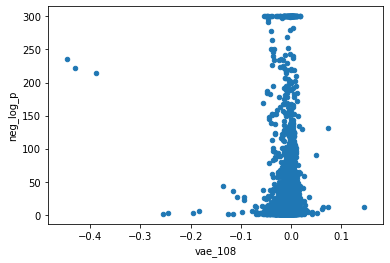

In [10]:
gtex_sex_feature.plot(kind="scatter", x=gtex_feature, y="neg_log_p")

## TCGA Sex Signature

In [11]:
tcga_seed = '451283'
tcga_k = 90
tcga_feature = "ica_44"

In [12]:
# Load the TCGA weight matrix containing the best sex feature
tcga_weight_df = (
    load_weight_matrix(dataset='TCGA',
                       z_dim=tcga_k,
                       seed=tcga_seed)
    .reset_index()
)

tcga_weight_df.gene_id = tcga_weight_df.gene_id.astype(str)
tcga_weight_df.head()

,gene_id,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,...,dae_80,dae_81,dae_82,dae_83,dae_84,dae_85,dae_86,dae_87,dae_88,dae_89
0,213,0.001632,0.009098,0.015186,-0.006079,0.024162,0.019315,-0.009256,0.010782,0.024672,...,-0.027543,-0.163655,0.037061,-0.189563,-0.211534,0.024976,-0.030409,-0.258532,-0.210457,-0.179396
1,7038,-0.006516,0.003712,0.006179,-0.001222,-0.017978,-0.008492,-0.000103,-0.012612,0.004762,...,-0.065521,0.041185,-0.245434,-0.132005,-0.159159,-1.361707,0.078414,-0.100687,-0.115015,-0.141470
2,1277,0.000600,-0.001438,-0.000483,0.005675,-0.001087,-0.002049,-0.005680,0.000143,-0.001382,...,-0.009330,0.108808,0.038603,-0.211261,-0.237126,-0.031896,-0.198858,-0.182453,-0.243779,-0.266969
3,2335,-0.004013,-0.001402,0.007743,0.011443,-0.005816,-0.004384,-0.013617,-0.005412,0.001746,...,-0.064458,0.020207,-0.009285,-0.245903,-0.262645,0.075820,-0.161266,-0.063993,-0.243267,-0.237635
4,3852,0.011302,-0.015284,-0.006901,0.024058,0.018579,-0.030537,-0.010623,-0.001460,0.035389,...,0.008421,-0.018872,0.009387,-0.244957,-0.278920,-0.924452,0.172537,-0.358692,-0.275843,-0.242674


In [13]:
# Align the weight matrix to the Sex Gene Database
tcga_sex_feature = (
    tcga_weight_df
    .merge(gene_df,
           left_on="gene_id",
           right_on="entrez_gene_id",
           how="left")
    .loc[:, gene_df.columns.tolist() + [tcga_feature]]
    .assign(abs_value_feature = tcga_weight_df.loc[:, tcga_feature].abs().tolist())
)

tcga_sex_feature.entrez_gene_id = tcga_sex_feature.entrez_gene_id.astype(str)

tcga_sex_feature = (
    tcga_sex_feature
    .merge(sex_gene_df,
           left_on="entrez_gene_id",
           right_on="entrez_gene_id",
           how="left")
    .sort_values(by="abs_value_feature", ascending=False)
    .dropna(subset=["entrez_gene_id", "Padj"])
    .reset_index(drop=True)
)

print(tcga_sex_feature.shape)
tcga_sex_feature.head(10)

(2213, 16)


,entrez_gene_id,symbol,description,chromosome,gene_type,synonyms,aliases,ica_44,abs_value_feature,Species,Symbol,FPKM(F),FPKM(M),log2(M/F ratio),Padj,neg_log_p
0,29978,UBQLN2,ubiquilin 2,X,protein-coding,"[ALS15, CHAP1, DSK2, HRIHFB2157, N4BP4, PLIC2]",ubiquilin-2|Nedd4 binding protein 4|protein li...,0.005253,0.005253,Human,UBQLN2,13.149286,3.683552,-2.1271,5.137800e-51,50.289223
1,10735,STAG2,stromal antigen 2,X,protein-coding,"[SA-2, SA2, SCC3B, bA517O1.1]",cohesin subunit SA-2|SCC3 homolog 2,0.004167,0.004167,Human,STAG2,13.465725,3.360696,-2.2956,1.147500e-65,64.940247
2,6191,RPS4X,"ribosomal protein S4, X-linked",X,protein-coding,"[CCG2, DXS306, RPS4, S4, SCAR, SCR10]","40S ribosomal protein S4, X isoform|cell cycle...",0.003983,0.003983,Human,RPS4X,851.960419,76.572459,-3.7718,4.599500e-132,131.337289
3,2000,ELF4,E74 like ETS transcription factor 4,X,protein-coding,"[ELFR, MEF]",ETS-related transcription factor Elf-4|E74-lik...,0.003949,0.003949,Human,ELF4,9.815378,2.421990,-2.2899,3.936700e-68,67.404868
4,24137,KIF4A,kinesin family member 4A,X,protein-coding,"[KIF4, KIF4G1, MRX100]",chromosome-associated kinesin KIF4A|chromokine...,0.003196,0.003196,Human,KIF4A,0.400995,4.648235,3.4191,1.263650e-20,19.898373
5,4478,MSN,moesin,X,protein-coding,[HEL70],moesin|epididymis luminal protein 70|membrane-...,0.003172,0.003172,Human,MSN,40.544603,11.707721,-2.0986,3.150500e-33,32.501621
6,60343,FAM3A,family with sequence similarity 3 member A,X,protein-coding,"[2.19, DLD, DXS560S, XAP-7]",protein FAM3A|cytokine-like protein 2-19,0.003168,0.003168,Human,FAM3A,19.683939,5.818768,-2.0517,1.912500e-47,46.718399
7,8273,SLC10A3,solute carrier family 10 member 3,X,protein-coding,"[DXS253E, P3]",P3 protein|Protein P3|solute carrier family 10...,0.002956,0.002956,Human,SLC10A3,28.580859,8.038733,-2.1508,1.373900e-22,21.862045
8,51186,TCEAL9,transcription elongation factor A like 9,X,protein-coding,"[WBP5, WEX6]",transcription elongation factor A protein-like...,0.002275,0.002275,Human,TCEAL9,128.580037,25.986596,-2.6090,3.574400e-32,31.446797
9,5230,PGK1,phosphoglycerate kinase 1,X,protein-coding,"[HEL-S-68p, MIG10, PGKA]",phosphoglycerate kinase 1|PRP 2|cell migration...,0.002266,0.002266,Human,PGK1,101.965342,460.756884,2.1874,0.000000e+00,300.000000


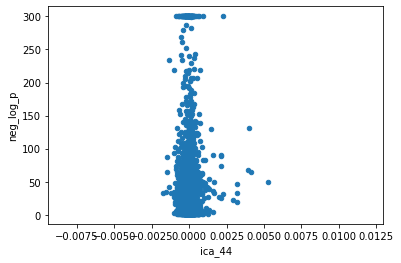

In [14]:
tcga_sex_feature.plot(kind="scatter", x=tcga_feature, y="neg_log_p")